## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

Using sharpened images (theshold 100.0 - see nb 04)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join

In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101_sharp'

In [10]:
NB_NUM='05_1'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 85e091bc, DATE: 20191109


In [12]:
UID='4dfccab9'
DATE='20191027'

In [13]:
SUB_NUM='16'

In [14]:
img_size=256

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}/un_n_sharp_t100'
test_images=data_dir/f'test/rotated/clipped/{img_size}/un_n_sharp_t100'

In [16]:
test_names = get_image_files(test_images)

In [17]:
assert len(test_names)==7325

In [18]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [19]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [20]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [21]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [22]:
assert len(df_test)==7325

In [23]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [24]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [25]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [26]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [27]:
data = (src.transform(tfms, size=img_size)
        .databunch().normalize(imagenet_stats))

In [28]:
#to check what params object has
#dir(data)

In [29]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256/un_n_sharp_t100

In [30]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

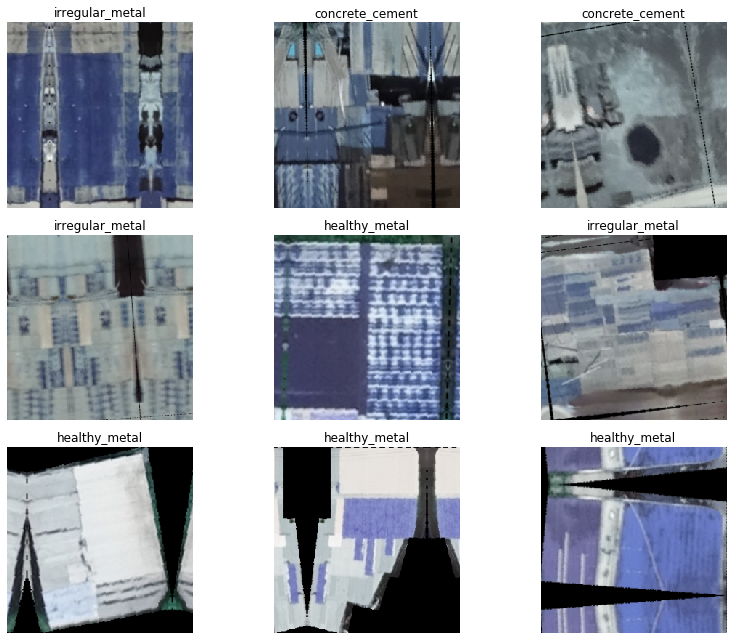

In [31]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [32]:
arch = models.resnet50
arch_name = 'rn50'

In [33]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True)

In [34]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

### Train model

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


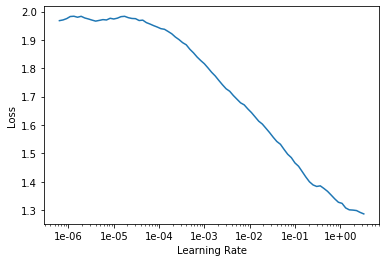

In [36]:
learn.recorder.plot()

Then we can fit the head of our network.

In [37]:
lr = 1e-1

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.513472,0.811336,0.243902,01:14
1,0.469618,0.542051,0.187361,01:12
2,0.456194,0.477819,0.171175,01:16
3,0.395971,0.370667,0.132151,01:15
4,0.357186,0.356512,0.124834,01:16


In [39]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [40]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256/un_n_sharp_t100, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 179),
 ('healthy_metal', 'irregular_metal', 137),
 ('incomplete', 'irregular_metal', 79),
 ('concrete_cement', 'healthy_metal', 34),
 ('other', 'healthy_metal', 34),
 ('healthy_metal', 'concrete_cement', 17),
 ('concrete_cement', 'irregular_metal', 15),
 ('incomplete', 'healthy_metal', 13),
 ('irregular_metal', 'concrete_cement', 12),
 ('incomplete', 'concrete_cement', 11),
 ('other', 'irregular_metal', 10),
 ('irregular_metal', 'incomplete', 9),
 ('healthy_metal', 'incomplete', 6),
 ('concrete_cement', 'incomplete', 4),
 ('other', 'concrete_cement', 2)]

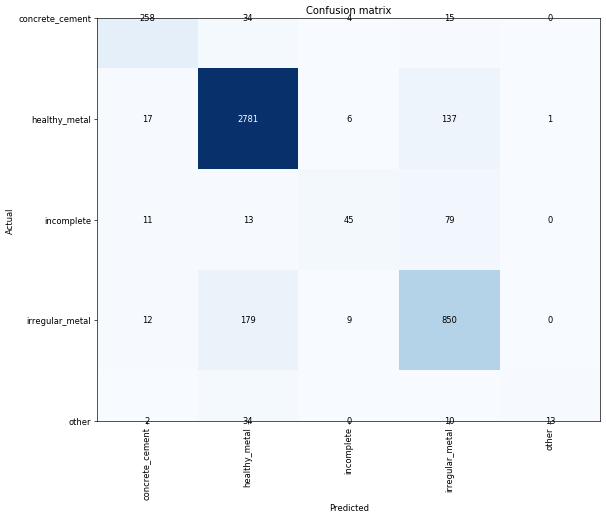

In [42]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [43]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


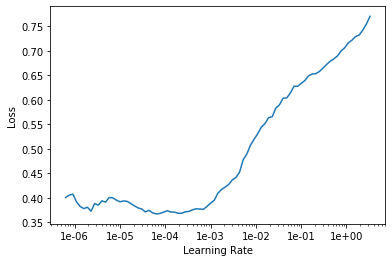

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.455046,1.107809,0.165410,01:37
1,0.419657,0.430861,0.161419,01:36
2,0.410904,0.415520,0.150554,01:37
3,0.365850,0.363733,0.129268,01:36
4,0.353637,0.356803,0.127273,01:36


In [46]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [47]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256/un_n_sharp_t100;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256/un_n_sharp_t100, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride

In [48]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.378038,0.424565,0.149446,01:36
1,0.391974,0.457677,0.145676,01:36
2,0.380771,0.376108,0.136364,01:36
3,0.349207,0.354372,0.125499,01:37
4,0.320612,0.349928,0.124169,01:36


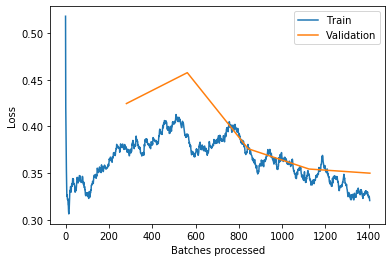

In [49]:
learn.recorder.plot_losses()

In [50]:
learn.save(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [51]:
learn.export(f'stage-2_1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [52]:
learn.export()

### inference

In [53]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [54]:
len(test_dataset)

7325

In [55]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [56]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [57]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [58]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [59]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [60]:
len(learn.dl(DatasetType.Test))

115

Get number of items in the Valid dataset (in DeviceDataLoader)

In [61]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [62]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [63]:
labels = np.argmax(preds, 1)

In [64]:
len(preds)

7325

In [65]:
preds[0].tolist()

[0.0629308745265007,
 0.9274115562438965,
 0.001016319845803082,
 0.007238989695906639,
 0.0014022411778569221]

In [66]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [67]:
len(labels)

7325

In [68]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [69]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [70]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [71]:
test_predictions[0]

'healthy_metal'

In [72]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [73]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a486800.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a4c49fc.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a501f50.tif'),
       PosixPath('data/test/rotated/clipped/256/un_n_sharp_t100/7a4d27b4.tif')], dtype=object)

In [74]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [75]:
preds_list[0]

[0.0629308745265007,
 0.9274115562438965,
 0.001016319845803082,
 0.007238989695906639,
 0.0014022411778569221]

In [76]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [77]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [78]:
df.head()

,id,pred
0,7a4d9168,"[0.0629308745265007, 0.9274115562438965, 0.001..."
1,7a4ae922,"[0.027198731899261475, 0.9552161693572998, 0.0..."
2,7a48ca98,"[0.0018392581259831786, 0.04761853814125061, 0..."
3,7a49c614,"[0.004468765575438738, 0.6628429889678955, 0.0..."
4,7a4dd4f2,"[0.0023725242353975773, 0.6176864504814148, 0...."


In [79]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [80]:
pred_df.insert(loc=0, column='id', value=ids)

In [81]:
pred_df.columns = cols

In [82]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.062931,0.927412,0.001016,0.007239,0.001402
1,7a4ae922,0.027199,0.955216,0.003253,0.011528,0.002804
2,7a48ca98,0.001839,0.047619,0.014673,0.934436,0.001433
3,7a49c614,0.004469,0.662843,0.002456,0.328902,0.001331
4,7a4dd4f2,0.002373,0.617686,0.002366,0.365965,0.011609


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [83]:
pred_ids=pred_df['id'].values.tolist()

In [84]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [85]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [86]:
baseline_ids=df_baseline['id'].values.tolist()

In [87]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [88]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [89]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.062931,0.927412,0.001016,0.007239,0.001402,7a4d9168
1,7a4ae922,0.027199,0.955216,0.003253,0.011528,0.002804,7a4ae922
2,7a48ca98,0.001839,0.047619,0.014673,0.934436,0.001433,7a48ca98
3,7a49c614,0.004469,0.662843,0.002456,0.328902,0.001331,7a49c614
4,7a4dd4f2,0.002373,0.617686,0.002366,0.365965,0.011609,7a4dd4f2


In [90]:
pred_df=pred_df.sort_values('id_cat')

In [91]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
716,7a4d630a,0.000964,0.991899,0.001250,0.003872,0.002015,7a4d630a
764,7a4bbbd6,0.002175,0.991627,0.000803,0.004684,0.000711,7a4bbbd6
1841,7a4ac744,0.008024,0.417557,0.010922,0.561353,0.002144,7a4ac744
3363,7a4881fa,0.001661,0.018901,0.010896,0.968236,0.000307,7a4881fa
133,7a4aa4a8,0.004693,0.853668,0.002853,0.135639,0.003147,7a4aa4a8


In [92]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [93]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)